In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import interpolate
pi = np.pi
np.set_printoptions(precision=3)


In [17]:
def readAirfoilDat( airfoilName ):
    currentDir = os.path.abspath(os.getcwd())
    filepath = currentDir + "/" + airfoilName + ".dat"
    print( filepath )
    if os.path.exists(filepath):
        f = open(filepath, "r")
        airfoilDat = f.read()
        f.close()
        return airfoilDat
    else:
        print("The file does not exist")
        
def processDat( airfoilDat ):
    airfoilDat = (" ".join(airfoilDat.split())).split()
    N = len(airfoilDat)
    x = []
    y = []
    for i in range( 0, N, 2 ):
        x.append( float( airfoilDat[i] ) )
        y.append( float( airfoilDat[i+1] ) )
    id = y.index(max( y ))
    displacement = x[id]
    i = 0
    for xx in x:
        x[i] = x[i] - displacement
        i = i + 1    
    
    x = np.asarray(x)
    y = np.asarray(y)
    x = x.astype(np.float)
    y = y.astype(np.float)
    return x, y

In [18]:
def createPeriodicSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0, per=1)
    return tck

def createSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0 )
    return tck

def computeNodeLocations( N, tck ):
    t = np.linspace( 0, 1, N )
    x, y = interpolate.splev(t, tck)
    return x, y

def computeNormParameterizationDerivative( N, tck ):
    t = np.linspace( 0, 1, N )
    dx_dt, dy_dt = interpolate.splev(t, tck, der=1)
    ds_dt = np.sqrt( dx_dt**2 + dy_dt**2 )
    return ds_dt

## this function I think is unnecessary but not sure
def computeRadial( N, tck ):
    t = np.linspace( 0, 1, N )
    rx, ry = interpolate.splev(t, tck)
    norm = np.sqrt( rx**2 + ry**2 )
    return rx/norm, ry/norm

def computeTangent( N, tck ):
    t = np.linspace( 0, 1, N )
    tx, ty = interpolate.splev(t, tck, der=1)
    norm = np.sqrt( tx**2 + ty**2 )
    return tx/norm, ty/norm

def computeNormal( N, tck ):
    t = np.linspace( 0, 1, N )
    nx, ny = interpolate.splev(t, tck, der=2)
    norm = -np.sqrt( nx**2 + ny**2 )
    return nx/norm, ny/norm

def computeBinormal( N, tck ):
    tx, ty = computeTangent( N, tck )
    nx, ny = computeNormal( N, tck )
    tangentVector = np.vstack( (tx, ty) )
    normalVector = np.vstack( (nx, ny) )
    binormal = np.cross( np.transpose(tangentVector), np.transpose(normalVector) )
    return -binormal

def computeCurvature( N, tck ):
    t = np.linspace( 0, 1, N )
    d1x, d1y = interpolate.splev(t, tck, der=1)
    d2x, d2y = interpolate.splev(t, tck, der=2)
    curvature = (d2x*d1y - d2y*d1x) / (d1x**2+d1y**2)**(3/2)
    return curvature

def computeChordLength( X ):
    return np.max(X) - np.min(X)

def createWakeGeometry( X, Y, AOA ):
    chordLength = computeChordLength( X )
    wakeLength = 5 * chordLength
    x0 = .5 * ( X[0] + X[-1] )
    y0 = .5 * ( Y[0] + Y[-1] )
    xf = x0 + wakeLength * np.cos( AOA * pi/180 )
    yf = y0 + wakeLength * np.sin( AOA * pi/180 )
    Xw = np.asarray( [x0, xf] )
    Yw = np.asarray( [y0, yf] )
    tck, u = interpolate.splprep([Xw, Yw], k=1, s=0, quiet=True )
    return tck

def computeWakeNormal( Nw, AOA ):
    nxw = -np.sin( AOA * pi/180 ) * np.ones( Nw )
    nyw = np.cos( AOA * pi/180 ) * np.ones( Nw )
    return nxw, nyw
    

In [50]:
def computeGreenNormal2D( x, y, xj, yj , normalx, normaly ):
    rj2 = (x - xj)**2 + (y - yj)**2
    dGdr = ( 1 / 2 / pi ) / rj2 
    gradrn = normalx * (x - xj) + normaly * (y - yj)
    return -dGdr * gradrn

def computeSolidAngle( xp, yp, xh1, yh1, xh2, yh2 ):
    vector1 = np.array( [ xh1-xp, yh1-yp ])
    vector2 = np.array( [ xh2-xp, yh2-yp ])
    vnorm1 = np.linalg.norm( vector1 )
    vnorm2 = np.linalg.norm( vector2 )
    solidAngle = np.arccos( np.dot( vector1, vector2 ) / vnorm1 / vnorm2 )
    return solidAngle/2/pi

def assembleMatrixSystem( X, Y, N, Nw, U0, AOA ):
    ## check if the geometry has sharp trailing edge
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    tx, ty = computeTangent( N+1, tck )
    x, y = computeNodeLocations( N+1, tck )
    theta = np.arctan2( y[:], x[:] )
    ds_dt = computeNormParameterizationDerivative( N+1, tck )
    nx, ny = computeNormal( N+1, tck )
    binormal = computeBinormal( N+1, tck )
    curvature = computeCurvature( N+1, tck )

    ## correct normal direction
    nx = binormal * nx
    ny = binormal * ny
    
    ## generate system of equations
    A = np.identity( N + 2 )
    b = np.zeros( N + 2 )
    dt = 1/ N
    ## nonlifting component
    useRegul = False
    tol = 1e-12
    for i in range( N+1 ):
        b[i] = U0 * ( x[i] * np.cos( AOA * pi / 180 ) +  y[i] * np.sin( AOA * pi / 180 ) )
        for j in range( N ):
            cond1 = (np.abs( (x[i]-x[j])**2 + (y[i]-y[j])**2 ) < tol) and (i != j) and np.abs(i-j) > 2
            cond2 = (np.abs( (x[i]-x[j+1])**2 + (y[i]-y[j+1])**2 ) < tol) and (i != j+1) and np.abs(i-j-1) > 2
            if (cond1 or cond2) == True:
                useRegul = True
            ## first part
            if (i != j):
                if useRegul == True:
                    gij = computeSolidAngle( x[i], y[i], x[j], y[j], x[j+1], y[j+1] ) / 2
                else:
                    gij = computeGreenNormal2D( x[i], y[i], x[j], y[j], nx[j], ny[j] ) * ds_dt[j] * dt / 2
                A[i, i] = A[i, i] - gij
                A[i, j] = A[i, j] + gij
            ## second part
            if (i != j+1):
                if useRegul == True:
                    gij = computeSolidAngle( x[i], y[i], x[j], y[j], x[j+1], y[j+1] ) / 2
                else:
                    gij = computeGreenNormal2D( x[i], y[i], x[j+1], y[j+1], nx[j+1], ny[j+1] ) * ds_dt[j+1] * dt / 2
#                 if i == 0 and j+1 == N:
#                     gij = curvature[-1]/4/pi * ds_dt[-1] *  dt / 2
# #                     A[0, 0] = A[0, 0] - .25
                A[i, i] = A[i, i] - gij
                A[i, j+1] = A[i, j+1] + gij
            useRegul = False
    ## lifting component
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( Nw+1, tckw )
    nxw, nyw = computeWakeNormal( Nw+1, AOA )
    c = computeChordLength( x )
    ds = 5 * c / (Nw)
#     for i in range( N+1 ):
#         for k in range( Nw ):
#             ## first part
#             aik = computeGreenNormal2D( x[i], y[i], xw[k], yw[k], nxw[k], nyw[k] ) * ds / 2
#             A[i, N+1] = A[i, N+1] + aik
#             ## second part
#             aik = computeGreenNormal2D( x[i], y[i], xw[k+1], yw[k+1], nxw[k+1], nyw[k+1] ) * ds / 2
#             A[i, N+1] = A[i, N+1] + aik
    ## impose boundary condition
    A[N+1,0] = 1
    A[N+1,-1] = -1
    A[N+1,-2] = 1
#     b[-1] = np.cos( (90-AOA)*pi/180 ) * (y[0] - y[-1])
    return x, y, theta, A, b, ds_dt


        




/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat


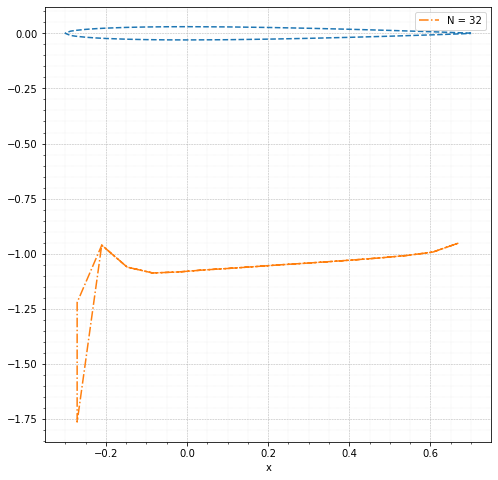

In [51]:
airfoilDat = readAirfoilDat( "NACA0006" )
X, Y = processDat( airfoilDat )
# Y= 10*Y
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel('x')
ax.plot( X, Y , '--' )



N = 32 
Nw = N
AOA = 0
U0 = 1




## create system of equations
x, y, theta, A, b, ds_dt = assembleMatrixSystem( X, Y, N, Nw, U0, AOA )
#     print( A )
## solve system of equations
phi = np.linalg.solve( A, b )

## plot solution


#     ax.plot( x, phi[:-1], '.', label="N = " + str(N))
# ax.plot( np.real(z), np.real(w), '--', label="Theoretical Solution" )

t = np.linspace(0, 1, N + 1)
dphi_ds = np.abs( np.diff( phi[:-1] ) / np.diff( t ) / ds_dt[:-1] )
#     dphi_ds = 1 - (dphi_ds/U0)**2
ax.plot( (x[:-1]+x[1:]) *.5, -dphi_ds, '-.', label="N = " + str(N) )
    
plt.legend()





/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat


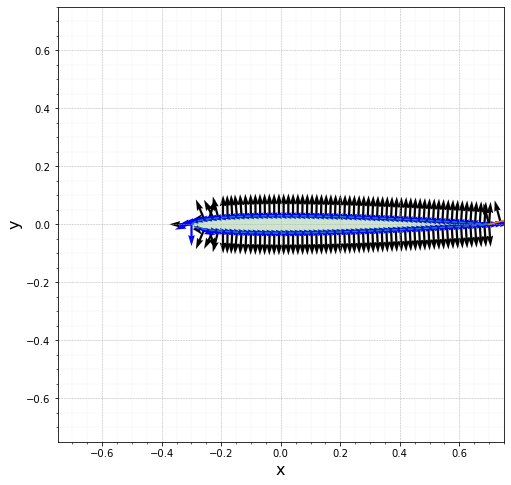

In [886]:
M = 1024 + 1
N = 128 + 1
Nw = 128 + 1
AOA = 15

## create geometry
c = 1
e = 0.5
a = c * ( 1 + e ) / 4

t = np.linspace( 0, 1, M )
X0 = - e * c / 4
X = a * np.cos( 2 * pi * t ) + X0
Y = a * np.sin( 2 * pi * t )
Z = X + 1j*Y
Z = Z + c**2/Z/16
X = np.real(Z)
Y = np.imag(Z)

airfoilDat = readAirfoilDat( "NACA0006" )
X, Y = processDat( airfoilDat )

## create B-spline representation
# tck = createPeriodicSplines( X[:-1], Y[:-1])
tck = createSplines( X, Y )
x, y = computeNodeLocations( 8*N, tck )

quiverx, quivery = computeNodeLocations( N, tck )
rx, ry = computeRadial( N, tck )
tx, ty = computeTangent( N, tck )
nx, ny = computeNormal( N, tck )
normalVector = np.vstack( (nx, ny) )
radialVector = np.vstack( (rx, ry) )
binormal = computeBinormal( N, tck )

## correct normal direction
nx = binormal * nx
ny = binormal * ny

# # create wake representation
# tckw = createWakeGeometry( X, Y, AOA )
# xw, yw = computeNodeLocations( 8*Nw, tckw )
# quiverxw, quiveryw = computeNodeLocations( Nw, tckw )
# # rxw, ryw = computeRadial( Nw, tckw )
# # txw, tyw = computeTangent( Nw, tckw )
# # nxw, nyw = computeNormal( Nw, tckw )
# nxw, nyw = computeWakeNormal( Nw, AOA )
# # normalVectorw = np.vstack( (nxw, nyw) )
# # radialVectorw = np.vstack( (rxw, ryw) )
# # binormalw = computeBinormal( Nw, tckw )
# # print( nx )
# # print( nxw )
    

fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel(xlabel='x', fontsize=16)
plt.ylabel(ylabel='y', fontsize=16)
D = .75
ax.set_xlim([-D, D])
ax.set_ylim([-D, D])

plt.plot( X, Y, '--', markersize=10, label="Original Points")
# plt.plot( x, y, '.', label="B-spline Representation")
plt.quiver( quiverx, quivery, nx, ny, width=.005 )
plt.quiver( quiverx, quivery, tx, ty, color='b', width=.005 )

plt.plot( xw, yw )
plt.quiver( quiverxw, quiveryw, nxw, nyw, width=.005 )
# plt.quiver( quiverxw, quiveryw, txw, tyw, color='b', width=.005 )






# legend = ax.legend(bbox_to_anchor=(.2, .5), loc='center', shadow=True, fontsize='large')

plt.fill( X, Y, alpha=0.2, facecolor='green' )




/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat


ValueError: x and y must have same first dimension, but have shapes (12,) and (13,)

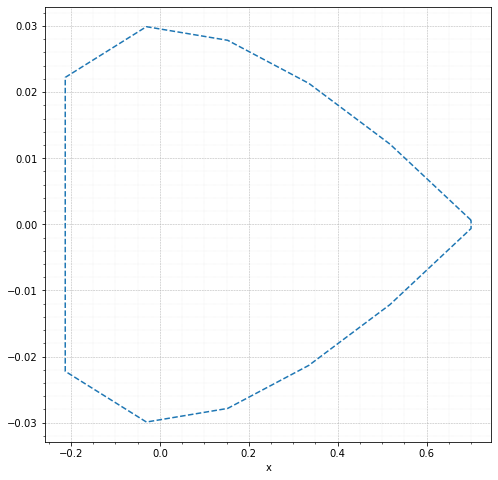

In [26]:
M = 1024*8 + 1
N = 10 + 1
Nw = N
AOA = 0
U0 = 1

## create geometry
c = 2
e = .25
a = c * ( 1 + e ) / 4

t = np.linspace( 0, 1, M )
X0 = - e * c / 4
X = a * np.cos( 2 * pi * t ) + X0
Y = a * np.sin( 2 * pi * t )
Z = X + 1j*Y
Z = Z + c**2/Z/16
X = np.real(Z)
Y = np.imag(Z)

airfoilDat = readAirfoilDat( "NACA0006" )
X, Y = processDat( airfoilDat )

## create system of equations
x, y, theta, A, b, ds_dt = assembleMatrixSystem( X, Y, N, Nw, U0, AOA )
# print( A )
# print( b )
# b[-1] = np.sin( AOA * pi/180)
## solve system of equations
phi = np.linalg.solve( A, b )

## plot solution
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel('x')
ax.plot( np.concatenate( (x,[x[0]]) ), np.concatenate( (y,[y[0]]) ), '--' )

ax.plot( x, phi, '.',  label="Numerical Solution" )
# ax.plot( np.real(z), np.real(w), '--', label="Theoretical Solution" )

t = np.linspace(0, 1, N + 1)
# t = ( t[1:] + t[:-1] ) * .5
# ## compute pressure coefficient
# dphi = np.diff( phi ) 
# L = np.sqrt( (x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2 ) 
# dphi_ds = dphi[:-1] / (L[1:] + L[:-1]) * 2
# cp = 1 - (dphi_ds/U0)**2
dphi_ds = np.abs( np.diff( phi ) / np.diff( t ) / ds_dt[:-1] )
ax.plot( (x[:-1]+x[1:]) *.5, dphi_ds, '-.', label="Tangential Velocity")
# dphi_ds = np.diff( phi ) / np.diff( t ) / ds_dt[:-1]
# cp = 1 - (dphi_ds/U0)**2
# ax.plot( (x[:-1]+x[1:]) *.5, cp, '-.', label="Tangential Velocity")



